### Topographic impacts on diagnosing fluxes

When estimating the thickness fluxes we need to take care how to handle bottom slopes. 

Particularly, we do not want to filter the bottom topography.

Thickness flux estimates when bottom interface of a layer has run into topography needs to be properly accounted for, a simple calculation of the form $\overline{u_nh_n} - \overline{u}_n\overline{h}_n$ does not suffice (as here the bottom interface gets filtered).

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [5]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/prog.zarr').isel(Time=slice(-2,None))

In [6]:
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Time: 2, zl: 2, yq: 441, xq: 401, zi: 3, yh: 440, xh: 400)
Coordinates:
  * Time     (Time) object 16B 0099-07-16 00:00:00 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 3kB 0.0 0.055 0.11 0.165 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * yq       (yq) float64 4kB 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables:
    RV       (Time, zl, yq, xq) float32 3MB dask.array<chunksize=(2, 2, 441, 401), meta=np.ndarray>
    e        (Time, zi, yh, xh) float32 4MB dask.array<chunksize=(2, 3, 440, 400), meta=np.ndarray>
    h        (Time, zl, yh, xh) float64 6MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    u        (Time, zl, yh, xq) float32 3MB dask.array<chunksize=(2, 2, 440, 401), meta=np.ndarray>
    v        (Time, zl, yq, xh) float32 3MB dask.array<chunksize=(2, 2, 441, 400), meta=np.ndarray>
Attributes:
    filename:   prog__000010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      MOM Experiment

In [7]:
## Create grid area element 
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

grid = Grid(ds, coords=coords, periodic=False)

dx = 110e3* grid.diff(ds.xq,'X', boundary='extend') * np.cos(ds.yh*np.pi/180)
dy = 110e3* grid.diff(ds.yq,'Y', boundary='extend')
area_t = dy*dx

In [11]:
def filter_dataset(ds): 

    ## parameters
    h_min = 20 #m
    
    dx_min = 1
    filter_scale = 20 # lat/lon points

    ## Make masks
    
    # make wet mask for layer thickness
    wet_mask_h = (ds.h>h_min).astype('float32').rename('wet_mask')
    # Add edges to domain
    wet_mask_h = wet_mask_h.where(ds.yh>=30.03, other=0)
    wet_mask_h = wet_mask_h.where(ds.xh>=0.03, other=0)

    # Make wet mask for interface points, by taking the mask for the layer below.
    wet_mask_e = wet_mask_h.copy()
    wet_mask_e = wet_mask_e.rename({'zl': 'zi'}).drop_vars('zi')
    #zeros_array = xr.DataArray(np.zeros((wet_mask_e.sizes['Time'], 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
    #                           dims=('Time', 'zi', 'yh', 'xh'))
    zeros_array = xr.DataArray(np.zeros((wet_mask_e.sizes['Time'], 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
                               dims=('Time','zi', 'yh', 'xh'))
    wet_mask_e = xr.concat([wet_mask_e, zeros_array], dim='zi').chunk({'zi':-1, 'xh':-1,'yh':-1})

    # make wet masks for interface but on zl points
    wet_mask_e_up = xr.DataArray(wet_mask_e.isel(zi=slice(0, -1)).data, 
                         dims=['Time','zl','yh','xh'])
    wet_mask_e_down = xr.DataArray(wet_mask_e.isel(zi=slice(1, None)).data, 
                         dims=['Time','zl','yh','xh'])


    filter_C_up = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e_up})

    filter_C_down = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e_down})

    filter_C_e = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e})

    ## Filter

    # Center velocities
    u_c = grid.interp(ds.u.fillna(0), 'X', boundary='extend')
    v_c = grid.interp(ds.v.fillna(0), 'Y', boundary='extend')

    # Bring interface values to zl, so they can be operated on with velocities
    e_up = xr.DataArray(ds.e.isel(zi=slice(0, -1)).data, 
                         dims=['Time','zl','yh','xh'])
    e_down = xr.DataArray(ds.e.isel(zi=slice(1, None)).data, 
                         dims=['Time','zl','yh','xh'])

    ebar_up = filter_C_up.apply(e_up, dims=['yh','xh'])
    ebar_down = filter_C_down.apply(e_down, dims=['yh','xh'])
    
    hbar = ebar_up - ebar_down 

    ebar = filter_C_e.apply(ds.e, dims=['yh','xh'])
    
    # u component
    ue_bar_up = filter_C_up.apply(u_c * e_up, dims=['yh','xh'])
    ue_bar_down = filter_C_down.apply(u_c * e_down, dims=['yh','xh'])

    ubar_up = filter_C_up.apply(u_c, dims=['yh','xh'])
    ubar_down = filter_C_down.apply(u_c, dims=['yh','xh'])
    ubar = ubar_up # mask for upper interface is same as that for a layer (if layer vanishes then interface is grounded).
    
    ubar_up_ebar_up =   ubar_up * ebar_up
    ubar_down_ebar_down =   ubar_down * ebar_down

    uh_bar = ue_bar_up - ue_bar_down
    ubar_hbar = ubar_up_ebar_up - ubar_down_ebar_down 

    uphp = uh_bar - ubar_hbar

    # v component
    ve_bar_up = filter_C_up.apply(v_c * e_up, dims=['yh','xh'])
    ve_bar_down = filter_C_down.apply(v_c * e_down, dims=['yh','xh'])

    vbar_up = filter_C_up.apply(v_c, dims=['yh','xh'])
    vbar_down = filter_C_down.apply(v_c, dims=['yh','xh'])
    vbar = vbar_up
    
    vbar_up_ebar_up = vbar_up * ebar_up
    vbar_down_ebar_down = vbar_down * ebar_down

    vh_bar = ve_bar_up - ve_bar_down
    vbar_hbar = vbar_up_ebar_up - vbar_down_ebar_down 

    vphp = vh_bar - vbar_hbar

    # Add ubar, vbar, hbar, ebar, uphp, vphp to a dataset
    ds_filt = xr.Dataset(coords=ds.coords)
    ds_filt['ubar'] = ubar
    ds_filt['vbar'] = vbar
    ds_filt['hbar'] = hbar
    ds_filt['ebar'] = ebar
    ds_filt['uphp'] = uphp
    ds_filt['vphp'] = vphp
    
    return ds_filt

In [12]:
def add_gradients(ds_filt): 
    ds_filt['dudx'] = grid.interp(grid.diff(ds_filt.ubar, 'X'), 'X')/dx
    ds_filt['dvdx'] = grid.interp(grid.diff(ds_filt.vbar, 'X'), 'X')/dx
    ds_filt['dudy'] = grid.interp(grid.diff(ds_filt.ubar, 'Y'), 'Y')/dy
    ds_filt['dvdy'] = grid.interp(grid.diff(ds_filt.vbar, 'Y'), 'Y')/dy
    
    ds_filt['dedx'] = grid.interp(grid.diff(ds_filt.ebar, 'X'), 'X')/dx
    ds_filt['dedy'] = grid.interp(grid.diff(ds_filt.ebar, 'Y'), 'Y')/dy

    ds_filt['dhdx'] = grid.interp(grid.diff(ds_filt.hbar, 'X'), 'X')/dx
    ds_filt['dhdy'] = grid.interp(grid.diff(ds_filt.hbar, 'Y'), 'Y')/dy

    return ds_filt
    

In [13]:
ds_filt  = add_gradients(filter_dataset(ds))

In [14]:
ds_filt

<xarray.Dataset> Size: 69MB
Dimensions:  (Time: 2, xh: 400, xq: 401, yh: 440, yq: 441, zi: 3, zl: 2)
Coordinates:
  * Time     (Time) object 16B 0099-07-16 00:00:00 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 3kB 0.0 0.055 0.11 0.165 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * yq       (yq) float64 4kB 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables: (12/14)
    ubar     (Time, zl, yh, xh) float32 3MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    vbar     (Time, zl, yh, xh) float32 3MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    hbar     (Time, zl, yh, xh) float32 3MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    ebar     (Time, zi, yh, xh) float32 4MB dask.array<chunksize=(2, 3, 440, 400), meta=np.ndarray>
    uphp     (Time, zl, yh, xh) float32 3MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    vphp     (Time, zl, yh, xh) float32 3MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    ...       ...
    dudy     (Time, zl, yh, xh) float64 6MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    dvdy     (Time, zl, yh, xh) float64 6MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    dedx     (Time, zi, yh, xh) float64 8MB dask.array<chunksize=(2, 3, 440, 400), meta=np.ndarray>
    dedy     (Time, zi, yh, xh) float64 8MB dask.array<chunksize=(2, 3, 440, 400), meta=np.ndarray>
    dhdx     (Time, zl, yh, xh) float64 6MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>
    dhdy     (Time, zl, yh, xh) float64 6MB dask.array<chunksize=(2, 2, 440, 400), meta=np.ndarray>

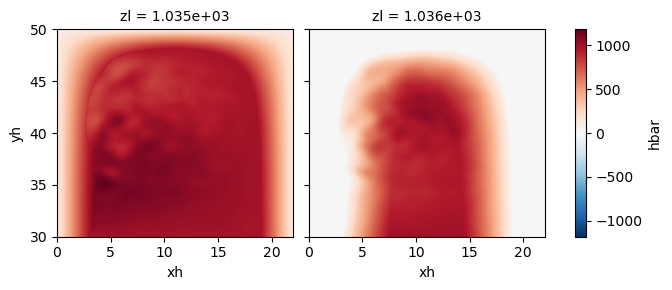

In [15]:
ds_filt.hbar.isel(Time=-1).plot(col='zl')

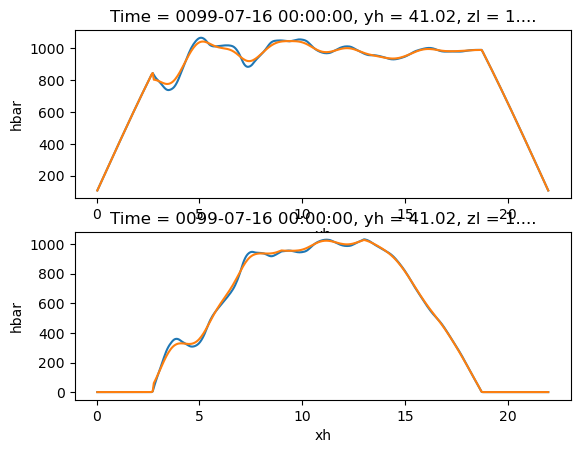

In [16]:
plt.subplot(211)
ds.h.isel(Time=0, zl=0).sel(yh=41, method='nearest').plot()
ds_filt.hbar.isel(Time=0, zl=0).sel(yh=41, method='nearest').plot()

plt.subplot(212)
ds.h.isel(Time=0, zl=1).sel(yh=41, method='nearest').plot()
ds_filt.hbar.isel(Time=0, zl=1).sel(yh=41, method='nearest').plot()


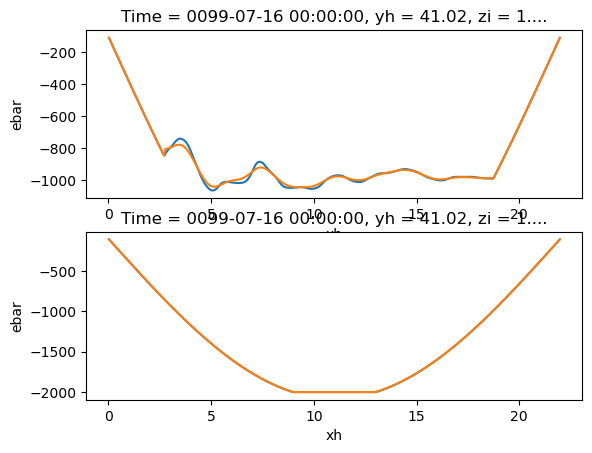

In [56]:
plt.subplot(211)
ds.e.isel(Time=0, zi=1).sel(yh=41, method='nearest').plot()
ds_filt.ebar.isel(Time=0, zi=1).sel(yh=41, method='nearest').plot()

plt.subplot(212)
ds.e.isel(Time=0, zi=2).sel(yh=41, method='nearest').plot()
ds_filt.ebar.isel(Time=0, zi=2).sel(yh=41, method='nearest').plot()


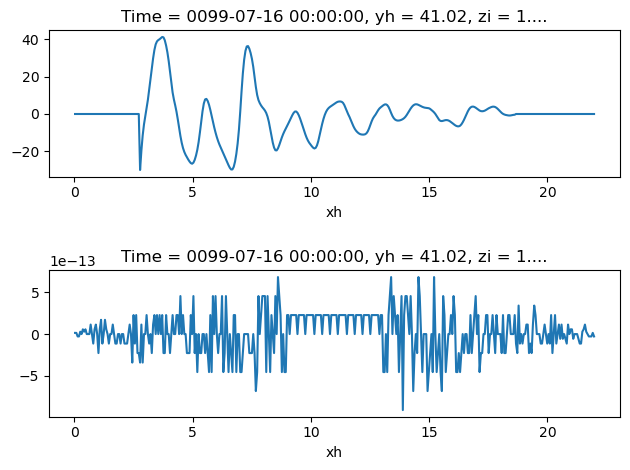

In [58]:
plt.subplot(211)
(ds.e - ds_filt.ebar).isel(Time=0, zi=1).sel(yh=41, method='nearest').plot()


plt.subplot(212)
(ds.e - ds_filt.ebar).isel(Time=0, zi=2).sel(yh=41, method='nearest').plot()

plt.tight_layout()


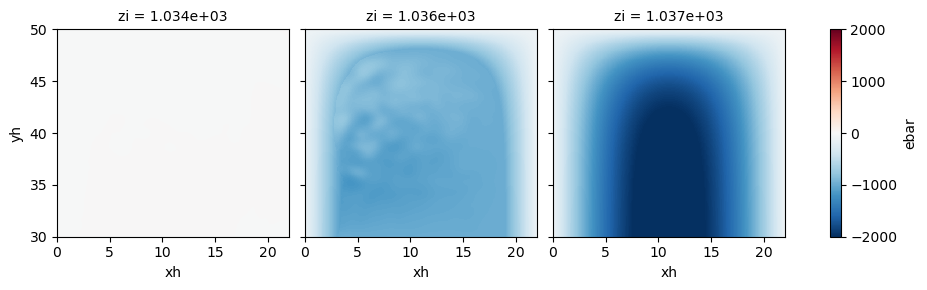

In [50]:
ds_filt.ebar.isel(Time=-1).plot(col='zi')

In [ ]:
ds_filt.ebar.isel(Time=-1).plot(col='zi')

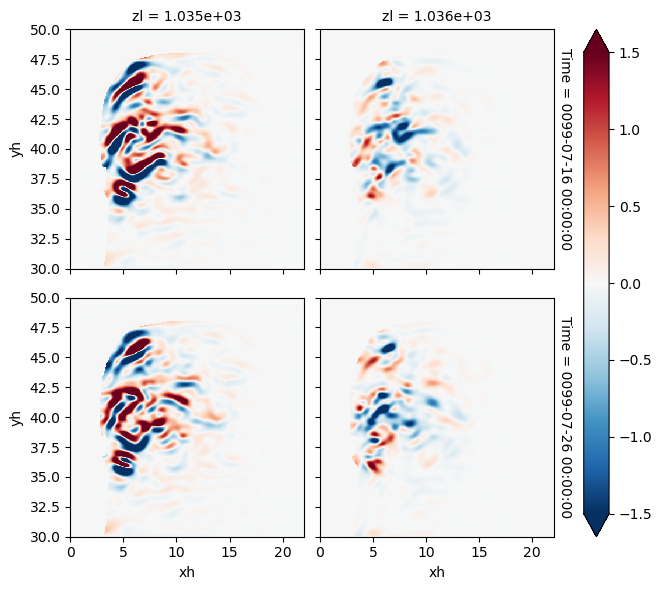

In [43]:
uphp.plot(col='zl', row='Time', vmin=-1.5)

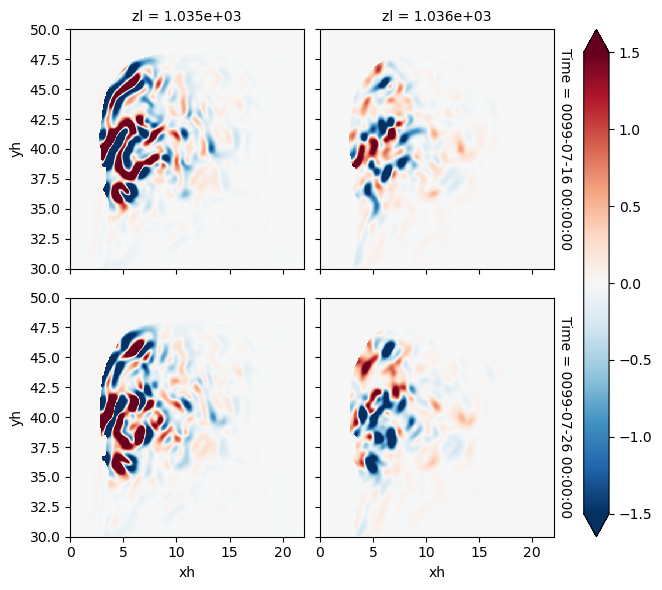

In [32]:
vphp.plot(col='zl', row='Time', vmin=-1.5)

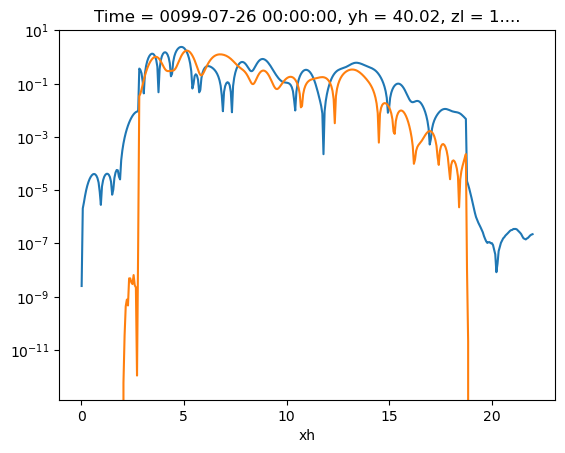

In [38]:
np.abs(uphp).isel(Time=-1, zl=0).sel(yh=40, method='nearest').plot(label='Layer 1')
np.abs(uphp).isel(Time=-1, zl=1).sel(yh=40, method='nearest').plot(label='Layer 2')
plt.yscale('log')

Note above that only in layer 2 does the flux become zero (when layer vanishes). In top layer it merely becomes small. 

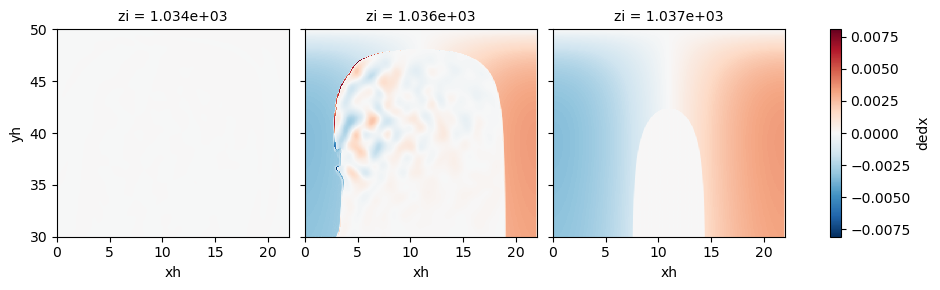

In [18]:
ds_filt.dedx.isel(Time=-1).plot(col='zi')

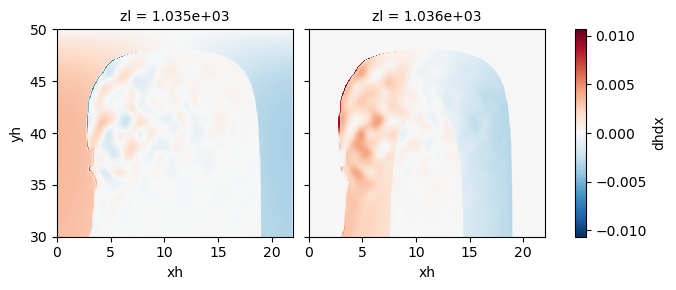

In [20]:
ds_filt.dhdx.isel(Time=-1).plot(col='zl')